In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Set up plotting preferences
plt.rc("font", size=14)
sns.set(style="whitegrid", color_codes=True)
warnings.simplefilter(action='ignore')

In [3]:
# Read train and test data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
# Rename columns for consistency
train_df = train_df.rename(columns={'Siblings/Spouses Aboard': 'SibSp', 'Parents/Children Aboard': 'Parch'})
test_df = test_df.rename(columns={'Siblings/Spouses Aboard': 'SibSp', 'Parents/Children Aboard': 'Parch'})

In [5]:
# Feature engineering for training data
train_df['TravelAlone'] = np.where((train_df["SibSp"] + train_df["Parch"]) > 0, 0, 1)
train_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
train_df = train_df.rename_axis('PassengerId').reset_index()
training = pd.get_dummies(train_df, columns=["Pclass", "Sex"])
training.drop(['Sex_female', 'PassengerId', 'Name'], axis=1, inplace=True)

# Add the 'IsMinor' feature
training['IsMinor'] = np.where(training['Age'] <= 16, 1, 0)

final_train = training

In [6]:
# Feature engineering for test data
test_df['TravelAlone'] = np.where((test_df["SibSp"] + test_df["Parch"]) > 0, 0, 1)
test_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_df = test_df.rename_axis('PassengerId').reset_index()
testing = pd.get_dummies(test_df, columns=["Pclass", "Sex"])
testing.drop(['Sex_female', 'PassengerId', 'Name'], axis=1, inplace=True)

# Add the 'IsMinor' feature
testing['IsMinor'] = np.where(testing['Age'] <= 16, 1, 0)

final_test = testing

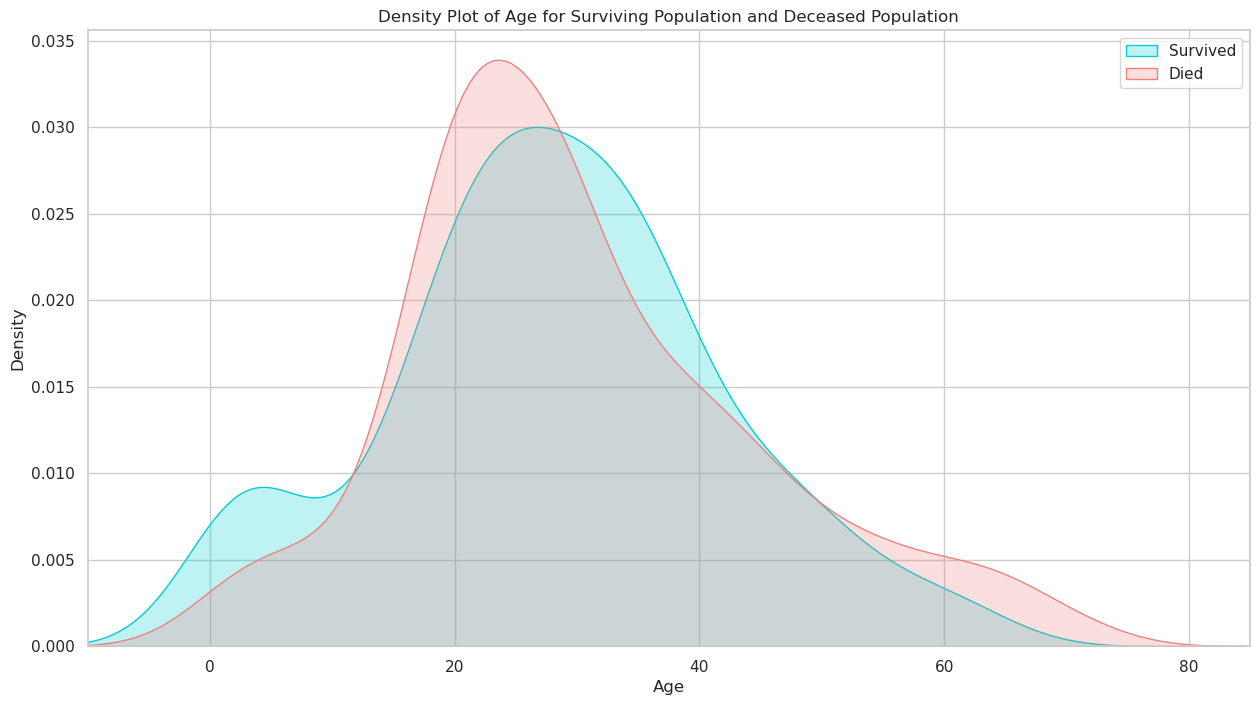

In [7]:
# Data visualization
plt.figure(figsize=(15, 8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10, 85)
plt.show()

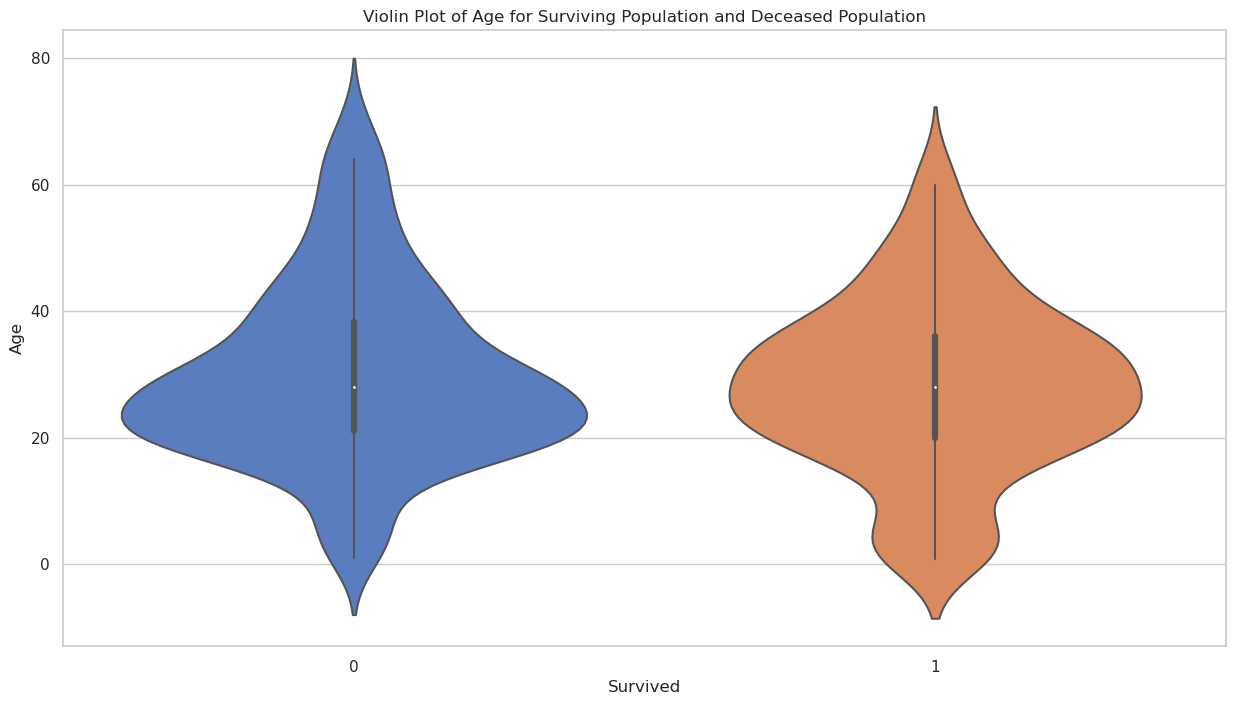

In [8]:
# Additional data visualizations

# Age distribution by survival status
plt.figure(figsize=(15, 8))
sns.violinplot(x="Survived", y="Age", data=final_train, palette="muted", split=True)
plt.title('Violin Plot of Age for Surviving Population and Deceased Population')
plt.show()

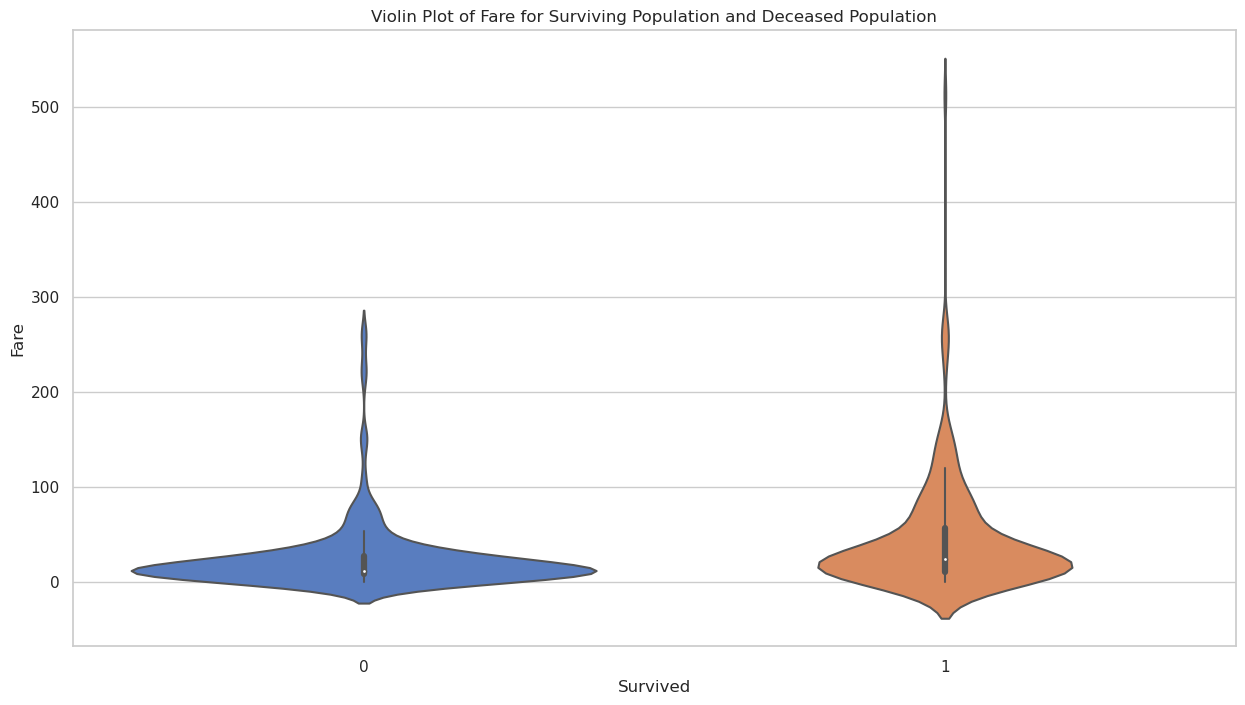

In [9]:
# Fare distribution by survival status
plt.figure(figsize=(15, 8))
sns.violinplot(x="Survived", y="Fare", data=final_train, palette="muted", split=True)
plt.title('Violin Plot of Fare for Surviving Population and Deceased Population')
plt.show()

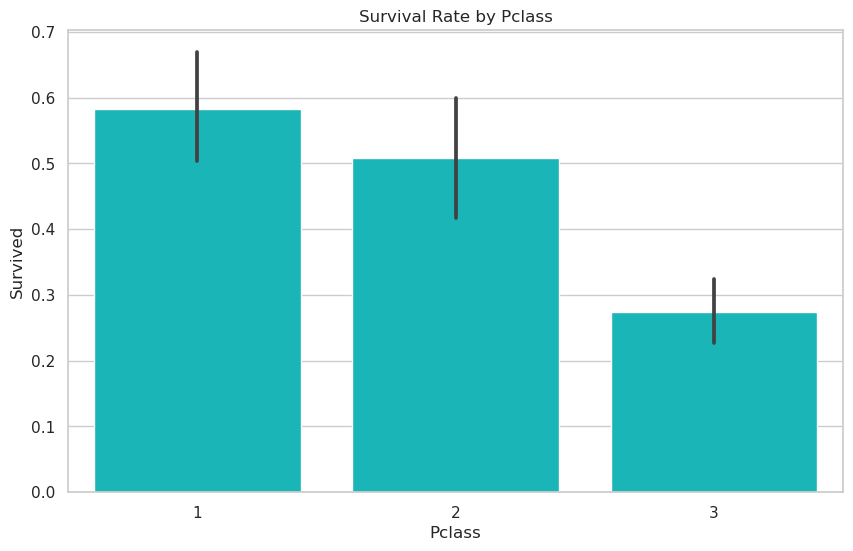

In [10]:
# Survival by Pclass
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', data=train_df, color="darkturquoise")
plt.title('Survival Rate by Pclass')
plt.show()

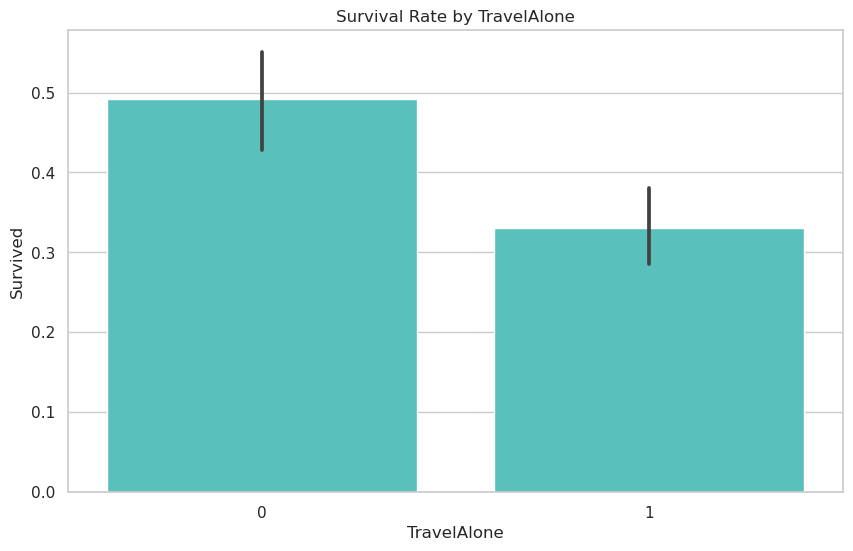

In [11]:
# Survival by TravelAlone
plt.figure(figsize=(10, 6))
sns.barplot(x='TravelAlone', y='Survived', data=final_train, color="mediumturquoise")
plt.title('Survival Rate by TravelAlone')
plt.show()

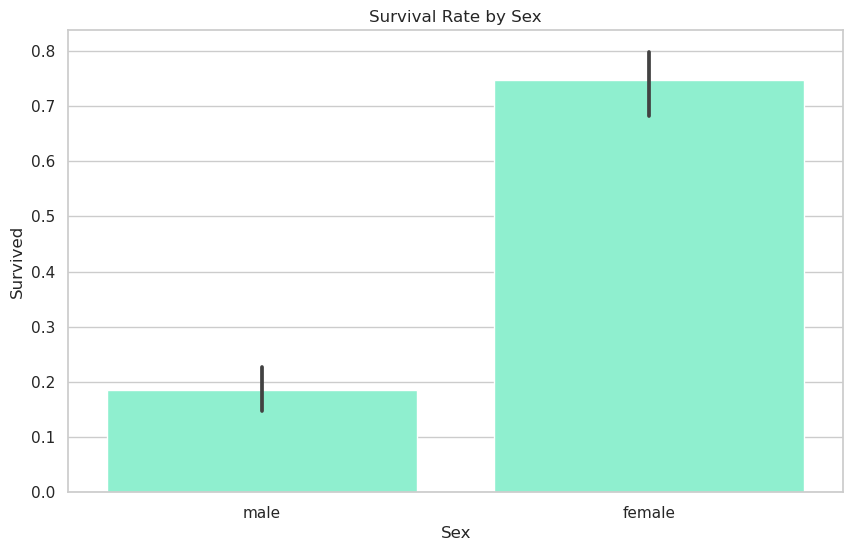

In [12]:
# Survival by Sex
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex', y='Survived', data=train_df, color="aquamarine")
plt.title('Survival Rate by Sex')
plt.show()

In [13]:
# Feature selection
cols = ["Age", "Fare", "TravelAlone", "Pclass_1", "Pclass_2", "Sex_male", "IsMinor"]
X_train = final_train[cols].values
y_train = final_train['Survived'].values.reshape(-1, 1)

In [14]:
# Normalize features
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

In [15]:
# Add bias term
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

In [24]:
# Use Recursive Feature Elimination (RFE) for feature selection
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    cost = (-1/m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))
    return cost[0]

def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    costs = []

    for _ in range(iterations):
        h = sigmoid(X @ theta)
        gradient = X.T @ (h - y) / m
        theta = theta - alpha * gradient.reshape(theta.shape)
        cost = compute_cost(X, y, theta)
        costs.append(cost)

    return theta, costs

In [17]:
# Initialize parameters
theta = np.zeros((X_train.shape[1], 1))

In [18]:
# Set hyperparameters
alpha = 0.01
iterations = 1000

In [19]:
# Train the model
theta, _ = gradient_descent(X_train, y_train, theta, alpha, iterations)

# Selected features
selected_features = cols

In [37]:
# Model evaluation using train set
def predict(X, theta):
    return sigmoid(X @ theta)

y_pred_train = (predict(X_train, theta) >= 0.5).astype(int)
accuracy_train = np.mean(y_pred_train == y_train)

print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.7868284228769498


In [38]:
# Additional evaluation metrics (similar to scikit-learn)
def compute_metrics(y_true, y_pred, y_prob):
    accuracy = np.mean(y_pred == y_true)
    log_loss = compute_cost(X, y_true.reshape(-1, 1), theta_final)
    auc = roc_auc_score(y_true, y_prob)
    return accuracy, log_loss, auc

# Cross-validation and hyperparameter tuning
def cross_validate_logistic_regression(X, y, alpha, iterations, folds=10):
    m = len(y)
    fold_size = m // folds

    accuracy_scores = []
    log_loss_scores = []
    auc_scores = []

    for i in range(folds):
        start_idx = i * fold_size
        end_idx = start_idx + fold_size if i < folds - 1 else m

        X_train_cv = np.concatenate([X[:start_idx], X[end_idx:]], axis=0)
        y_train_cv = np.concatenate([y[:start_idx], y[end_idx:]])
        X_val_cv = X[start_idx:end_idx]
        y_val_cv = y[start_idx:end_idx]

        # Normalize features
        X_train_cv = (X_train_cv - np.mean(X_train_cv, axis=0)) / np.std(X_train_cv, axis=0)
        X_val_cv = (X_val_cv - np.mean(X_val_cv, axis=0)) / np.std(X_val_cv, axis=0)

        # Add bias term
        X_train_cv = np.hstack((np.ones((X_train_cv.shape[0], 1)), X_train_cv))
        X_val_cv = np.hstack((np.ones((X_val_cv.shape[0], 1)), X_val_cv))

        # Initialize parameters
        theta_cv = np.zeros((X_train_cv.shape[1], 1))

        # Train the model
        theta_cv, _ = gradient_descent(X_train_cv, y_train_cv, theta_cv, alpha, iterations)

        # Predictions
        y_prob_cv = predict(X_val_cv, theta_cv)
        y_pred_cv = (y_prob_cv >= 0.5).astype(int)

        # Evaluation metrics
        accuracy_cv, log_loss_cv, auc_cv = compute_metrics(y_val_cv, y_pred_cv, y_prob_cv)

        accuracy_scores.append(accuracy_cv)
        log_loss_scores.append(log_loss_cv)
        auc_scores.append(auc_cv)

    average_accuracy = np.mean(accuracy_scores)
    average_log_loss = np.mean(log_loss_scores)
    average_auc = np.mean(auc_scores)

    return average_accuracy, average_log_loss, average_auc

In [40]:
# Define hyperparameter grid
alpha_values = [0.001, 0.01, 0.1, 1]
iteration_values = [100, 500, 1000]

best_alpha = None
best_iterations = None
best_accuracy = 0

In [41]:

# Print or visualize the results
print("Best Alpha:", best_alpha)
print("Best Iterations:", best_iterations)
print("Best Accuracy:", best_accuracy)

# Train final model with best hyperparameters
theta_final, _ = gradient_descent(X_train, y_train, np.zeros((X_train.shape[1], 1)), best_alpha, best_iterations)

# Evaluate final model on test set
X_test = final_test[Selected_features].values
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
y_prob_test = predict(X_test, theta_final)
y_pred_test = (y_prob_test >= 0.5).astype(int)

# Additional evaluation metrics (similar to scikit-learn)
final_accuracy, final_log_loss, final_auc = compute_metrics(y_test, y_pred_test, y_prob_test)

print("Final Accuracy:", final_accuracy)
print("Final Log Loss:", final_log_loss)
print("Final AUC:", final_auc)

Best Alpha: None
Best Iterations: None
Best Accuracy: 0


TypeError: 'NoneType' object cannot be interpreted as an integer